In [1]:
import numpy as np
import pickle
from sklearn.covariance import GraphicalLasso, GraphicalLassoCV
from sklearn.linear_model import Lasso
from scipy.stats import bernoulli
#import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from F import GL, Graph_Lasso, Implement, metric, X_gen, curve_auc, BIC #import classes/functions customized python script.
import warnings
warnings.filterwarnings("ignore")

# Edge set and data generation

In [51]:
P = 50 # dimension of features
N = 2000 # number of random samples
delta = 0.5 # to generate the source matrix

In [52]:
obj = GL(P, delta, 0.1) 
source_matrix = obj.Matrix_generation() # generate the true edge set.
(source_matrix==0).sum()

1996

In [47]:
X = X_gen(source_matrix,N, random_state=0)

## Implementation of two methods

### Node-wise Lasso

In [31]:
gl = Graph_Lasso(X, 0.)
NWL = gl.NWL()
#NWL

### Graphical Lasso

In [43]:
GRL = gl.GRL(500)
#GRL

# ROC and Precision-Recall  curve for various values of $\lambda$ 

In [48]:
lambds = np.linspace(0,1,101)
FPR_g = []
TPR_g = []
F1_g = []
precision_g = []

FPR_n1 = []
TPR_n1 = []
F1_n1 = []
precision_n1 = []

FPR_n2 = []
TPR_n2 = []
F1_n2 = []
precision_n2 = []

for i in lambds:
    gl = Graph_Lasso(X, i)
    a = gl.GRL()
    b = gl.NWL()
    hashm_g = metric(source_matrix, a)
    hashm_n1 = metric(source_matrix, b, "joint")
    hashm_n2 = metric(source_matrix, b, "or")
    
    FPR_g.append(hashm_g.get("FPR", 0))
    TPR_g.append(hashm_g.get("TPR", 0))
    precision_g.append(hashm_g.get("precision", 0))
    F1_g.append(hashm_g.get("F1", 0))
    
    FPR_n1.append(hashm_n1.get("FPR", 0))
    TPR_n1.append(hashm_n1.get("TPR", 0))
    precision_n1.append(hashm_n1.get("precision", 0))
    F1_n1.append(hashm_n1.get("F1", 0))
    
    FPR_n2.append(hashm_n2.get("FPR", 0))
    TPR_n2.append(hashm_n2.get("TPR", 0))
    precision_n2.append(hashm_n2.get("precision", 0))
    F1_n2.append(hashm_n2.get("F1", 0))


Transfer original data to plot-friendly data and calculate the AUC of ROC curve.

In [49]:
tpr_g, fpr_g, auc_g = curve_auc(TPR_g, FPR_g)
tpr_n1, fpr_n1, auc_n1 = curve_auc(TPR_n1, FPR_n1)
tpr_n2, fpr_n2, auc_n2 = curve_auc(TPR_n2, FPR_n2)

precision_g, recall_g, area_g = curve_auc(precision_g, TPR_g, "PR")
precision_n1, recall_n1, area_n1  = curve_auc(precision_n1, TPR_n1, "PR")
precision_n2, recall_n2, area_n2  = curve_auc(precision_n2, TPR_n2, "PR")

I include all curves in one single plot for a more intuitive view(PR is the Precision-Recall curve):

The following gives the ROC curve and Precision-Recall curve with corresponding parameter values:

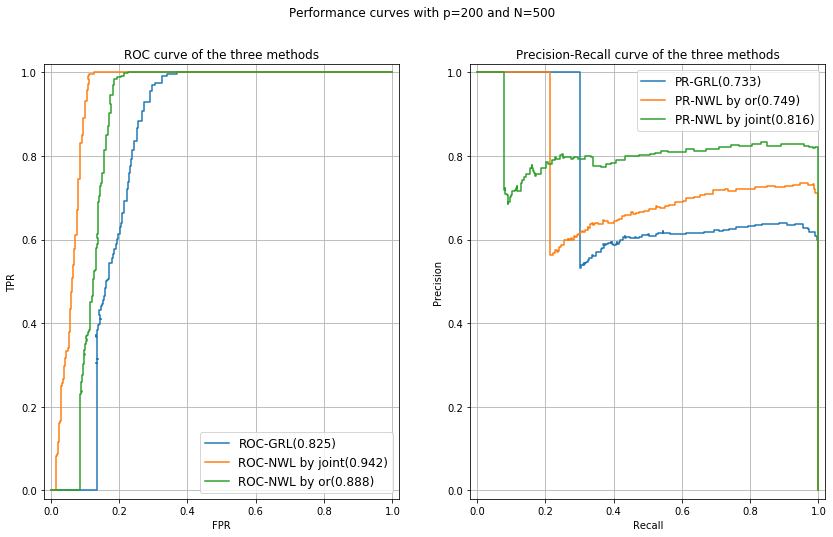

In [50]:
fig, ax = plt.subplots(1,2,figsize=(14,8))
ax[0].plot(fpr_g, tpr_g, label=f"ROC-GRL({np.around(auc_g, decimals=3)})")
ax[0].plot(fpr_n1, tpr_n1, label=f"ROC-NWL by joint({np.around(auc_n1, decimals=3)})")
ax[0].plot(fpr_n2, tpr_n2, label=f"ROC-NWL by or({np.around(auc_n2, decimals=3)})")
ax[0].set_title("ROC curve of the three methods", fontsize=(12))
ax[0].set_xlabel("FPR", fontsize=(10))
ax[0].set_ylabel("TPR", fontsize=(10))

ax[1].plot(recall_g, precision_g, label=f"PR-GRL({np.around(area_g, decimals=3)})")
ax[1].plot(recall_n2, precision_n2, label=f"PR-NWL by or({np.around(area_n2, decimals=3)})")
ax[1].plot(recall_n1, precision_n1, label=f"PR-NWL by joint({np.around(area_n1, decimals=3)})")
ax[1].set_title("Precision-Recall curve of the three methods", fontsize=(12))
ax[1].set_xlabel("Recall", fontsize=(10))
ax[1].set_ylabel("Precision", fontsize=(10))

ax[0].legend(fontsize=(12))
ax[0].set_ylim(-0.02,1.02)
ax[0].set_xlim(-0.02,1.02)
ax[0].grid()
ax[1].legend(fontsize=(12))
ax[1].set_ylim(-0.02,1.02)
ax[1].set_xlim(-0.02,1.02)
ax[1].grid()
fig.suptitle("Performance curves with p=200 and N=500")
#plt.savefig("Curve200.pdf")
plt.show()

# Parameter selection
In this part I use a function GraphicalLassoCV imported from sklearn package, and develop a BIC method to select the optimal tuning parameter $\lambda$. The results are compared to the true edge set.

In [45]:
gcv = GraphicalLassoCV().fit(X)
cv_get = np.around(gcv.precision_, decimals=3)
cv_get

array([[ 0.58 , -0.   ,  0.043, ..., -0.   , -0.045, -0.   ],
       [-0.   ,  0.554,  0.   , ...,  0.   , -0.018, -0.   ],
       [ 0.043,  0.   ,  0.538, ...,  0.071,  0.067,  0.   ],
       ...,
       [-0.   ,  0.   ,  0.071, ...,  0.662, -0.   ,  0.   ],
       [-0.045, -0.018,  0.067, ..., -0.   ,  0.572, -0.   ],
       [-0.   , -0.   ,  0.   , ...,  0.   , -0.   ,  0.762]])

In [46]:
gcv.alpha_

0.4586162725240761

In [37]:
BIC(X, np.linspace(0,0.5,21))

{'GRL': [0.05, 5949.192078391703],
 'NWL1': [0.17500000000000002, -158.41022546198417],
 'NWL2': [0.225, -158.41022546198417]}

# Try on 50 different datasets

In [109]:
X = np.stack([X_gen(source_matrix,500,i) for i in range(50)])

In [110]:
names = ["TP","FP","TN","FN","F1","area"]
GRL1_m = {name:[] for name in names}
GRL2_m = {name:[] for name in names}
NWL1_m = {name:[] for name in names}
NWL2_m = {name:[] for name in names}

In [111]:
for x in X:
    BIC_l = BIC(x, np.linspace(0,0.5,21))
    gcv_l = GraphicalLassoCV().fit(x).alpha_
    cls = Graph_Lasso(x)
    GRL1 = cls.GRL(lambd=BIC_l["GRL"][0])
    GRL2 = cls.GRL(lambd=gcv_l)
    NWL1 = cls.NWL(lambd=BIC_l["NWL1"][0])
    NWL2 = cls.NWL(lambd=BIC_l["NWL2"][0])
    for name in names:
        GRL1_m[name].append(metric(source_matrix, GRL1).get(name,0))
        GRL2_m[name].append(metric(source_matrix, GRL2).get(name,0))
        NWL1_m[name].append(metric(source_matrix, NWL1,"joint").get(name,0))
        NWL2_m[name].append(metric(source_matrix, NWL2,"or").get(name,0))

Pickle the above results, runs too long.

In [112]:
L = [GRL1_m, GRL2_m, NWL1_m, NWL2_m]
filename = 'newdata'
outfile = open(filename,'wb')
pickle.dump(L, outfile)
outfile.close()

In [113]:
l1 = []
l2 = []
l3 = []
l4 = []
for name in names[:4]:
    l1.append(GRL1_m[name])
    l2.append(GRL2_m[name])
    l3.append(NWL1_m[name])
    l4.append(NWL2_m[name])

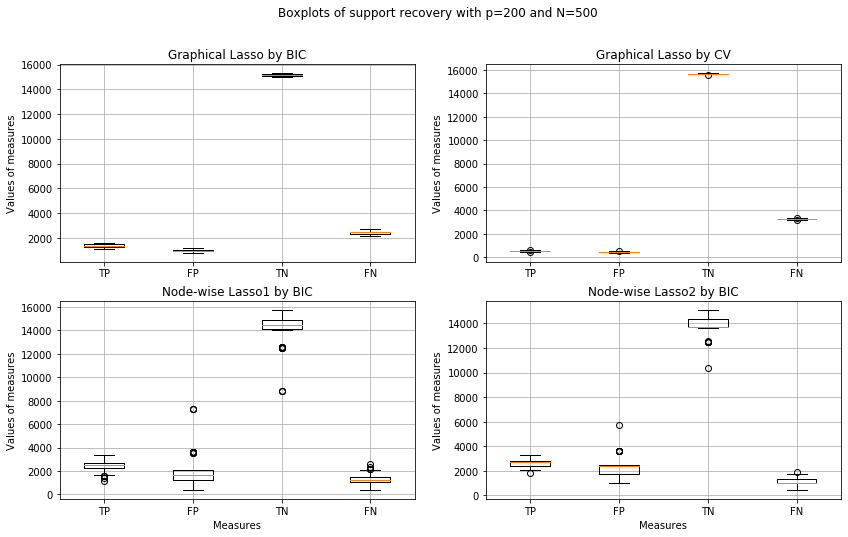

In [116]:
fig, ax = plt.subplots(2,2,figsize=(14,8))
ax[0][0].boxplot(l1)
ax[0][1].boxplot(l2)
ax[1][0].boxplot(l3)
ax[1][1].boxplot(l4)

ax[0][0].set_title("Graphical Lasso by BIC")
ax[0][1].set_title("Graphical Lasso by CV")
ax[1][0].set_title("Node-wise Lasso1 by BIC")
ax[1][1].set_title("Node-wise Lasso2 by BIC")
for i in range(2):
    for j in range(2):
        if i==1:
            ax[i][j].set_xlabel("Measures")
        ax[i][j].set_ylabel("Values of measures")
        ax[i][j].set_xticks([1,2,3,4])
        ax[i][j].set_xticklabels(["TP","FP","TN","FN"])
        ax[i][j].grid()
fig.suptitle("Boxplots of support recovery with p=200 and N=500")
plt.savefig("boxplot200.pdf")
plt.show()